In [1]:
%pip install torch torchvision matplotlib

import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importer Un dataset préfait (FGVCAircraft)

training_dataset = datasets.FGVCAircraft(
    root="data",
    split="train",
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.FGVCAircraft(
    root="data",
    split="test",
    download=True,
    transform=T.ToTensor()
)


In [73]:
# Afficher des informations sur le dataset
print(training_dataset)

# Accéder aux données et aux labels
image, label = training_dataset[0]  # Exemple du premier élément du dataset
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

# Parcourir toutes les cibles (labels)
all_labels = [training_dataset[i][1] for i in range(len(training_dataset))]
print(f"Nombre total de labels: {len(all_labels)}")
print(f"Labels uniques: {set(all_labels)}")


Dataset FGVCAircraft
    Number of datapoints: 3334
    Root location: data
    StandardTransform
Transform: ToTensor()
Image shape: torch.Size([3, 28, 28])
Label: 0
Nombre total de labels: 3334
Labels uniques: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..1.9602616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6475817..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5185376..1.8905448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5980392..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3472902..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.826783

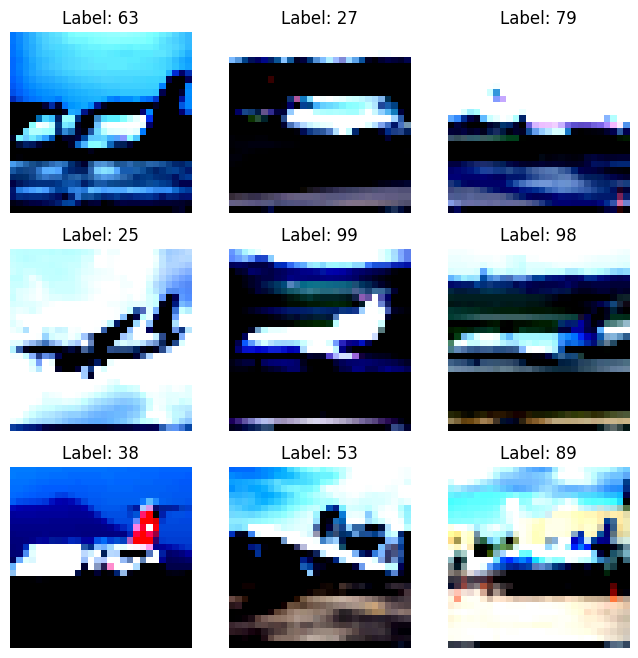

In [92]:
# Créer une figure pour afficher des exemples d'images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    # Sélectionner un index aléatoire
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    
    # Charger une image et son label
    img, label = training_dataset[sample_idx]
    
    # Ajouter un sous-graphique
    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label}")  # Afficher le label
    plt.axis("off")
    
    # Afficher l'image
    # img est un tenseur (C, H, W), on doit le transposer en (H, W, C) pour matplotlib
    plt.imshow(img.permute(1, 2, 0))  # Transposer pour matplotlib

plt.show()


In [78]:
transform = T.Compose([
    T.Resize((28, 28)),  # Redimensionner à 28x28
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Normalisation ImageNet
])

training_dataset.transform = transform
test_dataset.transform = transform

# Définir les DataLoaders
batch_size = 64
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Tester le DataLoader
for X, y in test_dataloader:
    print(f"Shape de X (images) : {X.shape}")
    print(f"Shape de y (labels) : {y.shape}")
    break


Shape de X (images) : torch.Size([64, 3, 28, 28])
Shape de y (labels) : torch.Size([64])


In [6]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape


torch.Size([64, 3, 28, 28])

In [8]:
class MLP(nn.Module):
    def __init__(self, dims, input_shape):
        """
        Initialise un MLP pour des dimensions données.
        :param dims: Liste des dimensions des couches [input_dim, hidden1, hidden2, ..., output_dim]
        :param input_shape: Tuple représentant la taille d'entrée (C, H, W)
        """
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()  # Aplatir les images
        input_dim = input_shape[0] * input_shape[1] * input_shape[2]  # C * H * W

        # Créer les couches entièrement connectées
        self.fcs = nn.ModuleList(
            [nn.Linear(input_dim if i == 0 else dims[i], dims[i+1]) for i in range(len(dims)-1)]
        )
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)  # Aplatir l'entrée
        for layer in self.fcs:
            x = layer(x)
            x = self.act(x)
        return x


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Accélérateur {device}")

input_shape = (3, 28, 28)  # Taille corrigée des images RGB
input_dim = input_shape[0] * input_shape[1] * input_shape[2]  # 3 x 28 x 28 = 2352
output_dim = 100  # Nombre de classes pour FGVCAircraft

model = MLP([input_dim, 128, 128, output_dim], input_shape).to(device)


Accélérateur cpu


In [10]:
model


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcs): ModuleList(
    (0): Linear(in_features=2352, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
  (act): ReLU()
)

In [93]:
loss_fn = nn.CrossEntropyLoss() # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 


In [94]:
# Fonction de boucle d'entraînement (mise à jour pour le GPU)
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Envoyer les données sur le GPU
        X, y = X.to(device), y.to(device)

        # Prédiction
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Affichage périodique des pertes
        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * len(X)
            print(f"Loss: {loss_value:>7f} [{current:>5d}/{len(dataloader.dataset)}]")

# Fonction de boucle de test (mise à jour pour le GPU)
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # Envoyer les données sur le GPU
            X, y = X.to(device), y.to(device)

            # Prédiction
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test loss: {test_loss:>8f} | Test accuracy: {(correct * 100):>0.2f}%")


In [95]:
# Boucle principale
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1} ------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")


Epoch 1 ------------------------
Loss: 3.682770 [    0/3334]
Test loss: 4.605170 | Test accuracy: 0.99%
Epoch 2 ------------------------
Loss: 4.605170 [    0/3334]
Test loss: 4.605170 | Test accuracy: 0.99%
Epoch 3 ------------------------
Loss: 4.605170 [    0/3334]
Test loss: 4.605170 | Test accuracy: 0.99%
Done!


normalisation

In [14]:
# Importer Un dataset préfait (FGVCAircraft)

training_dataset = datasets.FGVCAircraft(
    root="data",
    split="train",
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.FGVCAircraft(
    root="data",
    split="test",
    download=True,
    transform=T.ToTensor()
)


In [16]:
#mean, variance des images
from torch.utils.data import ConcatDataset

# Initialiser mean et std comme des tenseurs de dimension (3,) pour chaque canal (R, G, B)
mean = torch.zeros(3)
std = torch.zeros(3)

# Combiner les datasets d'entraînement et de test
combined_data = ConcatDataset([training_dataset, test_dataset])

# Nombre total d'images
num_images = len(combined_data)

for image, label in combined_data:
    # Vérifier que l'image est bien en format (C, H, W)
    if image.ndim == 3:
        mean += image.mean(dim=(1, 2))  # Moyenne par canal
        std += image.std(dim=(1, 2))   # Écart-type par canal
    else:
        raise ValueError(f"L'image doit être en format (C, H, W), mais elle a la forme {image.shape}")

# Calculer la moyenne et l'écart-type finaux
mean /= num_images
std /= num_images

print(f"Mean (par canal): {mean}")
print(f"Standard deviation (par canal): {std}")


Mean (par canal): tensor([0.4787, 0.5102, 0.5343])
Standard deviation (par canal): tensor([0.1956, 0.1943, 0.2160])


In [18]:
# Importer Un dataset préfait (FGVCAircraft)

training_dataset_V2 = datasets.FGVCAircraft(
    root="data",
    split="train",
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize(mean, std)])
)

test_dataset_V2 = datasets.FGVCAircraft(
    root="data",
    split="test",
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize(mean, std)])
)


In [20]:
#mean, variance des images
from torch.utils.data import ConcatDataset

# Initialisation des variables pour la moyenne et la variance
mean = torch.zeros(3)  # Une valeur pour chaque canal (R, G, B)
std = torch.zeros(3)

# Combiner les datasets d'entraînement et de test
combined_data = ConcatDataset([training_dataset_V2, test_dataset_V2])

# Calculer la moyenne et la variance pour chaque canal
for image, label in combined_data:
    # Assurez-vous que l'image est sous forme de tenseur avec les dimensions (C, H, W)
    if len(image.shape) == 3:  # (C, H, W)
        for c in range(3):  # Parcourir chaque canal
            mean[c] += image[c, :, :].mean()
            std[c] += image[c, :, :].std()
    else:
        raise ValueError("Les images doivent être au format (C, H, W).")

# Diviser par le nombre total d'images pour obtenir la moyenne
mean /= len(combined_data)
std /= len(combined_data)

print(f"Mean (R, G, B): {mean}")
print(f"Standard Deviation (R, G, B): {std}")


Mean (R, G, B): tensor([ 1.6492e-06,  2.5082e-06, -5.5617e-06])
Standard Deviation (R, G, B): tensor([1.0000, 1.0000, 1.0000])


In [21]:
training_dataset[0]


(tensor([[[0.8588, 0.8549, 0.8588,  ..., 0.8745, 0.8706, 0.8627],
          [0.8510, 0.8627, 0.8706,  ..., 0.8588, 0.8627, 0.8706],
          [0.8510, 0.8667, 0.8706,  ..., 0.8667, 0.8745, 0.8784],
          ...,
          [0.0000, 0.2275, 0.3961,  ..., 0.0118, 0.0039, 0.0078],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0157, 0.0157, 0.0235,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.8588, 0.8549, 0.8588,  ..., 0.8745, 0.8706, 0.8627],
          [0.8510, 0.8627, 0.8706,  ..., 0.8588, 0.8627, 0.8706],
          [0.8510, 0.8667, 0.8706,  ..., 0.8667, 0.8745, 0.8784],
          ...,
          [0.0353, 0.2745, 0.4510,  ..., 0.0039, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.8588, 0.8549, 0.8588,  ..., 0.8745, 0.8706, 0.8627],
          [0.8510, 0.8627, 0.8706,  ..., 0.8588, 0.8627, 0.8706],
          [0.8510, 0.8667, 0.8706,  ...,

In [22]:
training_dataset_V2[0]


(tensor([[[ 1.9430,  1.9229,  1.9430,  ...,  2.0232,  2.0031,  1.9630],
          [ 1.9029,  1.9630,  2.0031,  ...,  1.9430,  1.9630,  2.0031],
          [ 1.9029,  1.9831,  2.0031,  ...,  1.9831,  2.0232,  2.0432],
          ...,
          [-2.4470, -1.2844, -0.4224,  ..., -2.3869, -2.4270, -2.4069],
          [-2.4470, -2.4270, -2.4470,  ..., -2.4470, -2.4470, -2.4270],
          [-2.3668, -2.3668, -2.3267,  ..., -2.4470, -2.4470, -2.4470]],
 
         [[ 1.7944,  1.7742,  1.7944,  ...,  1.8751,  1.8549,  1.8146],
          [ 1.7540,  1.8146,  1.8549,  ...,  1.7944,  1.8146,  1.8549],
          [ 1.7540,  1.8347,  1.8549,  ...,  1.8347,  1.8751,  1.8953],
          ...,
          [-2.4442, -1.2130, -0.3048,  ..., -2.6057, -2.6259, -2.6259],
          [-2.5855, -2.5855, -2.5855,  ..., -2.6259, -2.6259, -2.6057],
          [-2.6259, -2.6259, -2.6259,  ..., -2.6259, -2.6259, -2.6259]],
 
         [[ 1.5022,  1.4841,  1.5022,  ...,  1.5749,  1.5567,  1.5204],
          [ 1.4659,  1.5204,

In [24]:
from torch.utils.data import DataLoader

# Définir le batch size
batch_size = 64

# Ajouter une transformation pour redimensionner les images
transform = T.Compose([
    T.Resize((28, 28)),  # Redimensionner à 28x28
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Normalisation ImageNet
])

# Appliquer la transformation aux datasets
training_dataset.transform = transform
test_dataset.transform = transform

# Créer les DataLoaders pour entraînement et test
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Parcourir un batch de test
for X, y in test_dataloader:
    print(f"Shape de X (images): {X.shape}")  # Dimensions des images dans le batch
    print(f"Shape de y (labels): {y.shape}")  # Dimensions des labels dans le batch
    print(f"Labels uniques dans le batch: {y.unique()}")
    break


Shape de X (images): torch.Size([64, 3, 28, 28])
Shape de y (labels): torch.Size([64])
Labels uniques dans le batch: tensor([0, 1])


In [26]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1} ------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")


Epoch 1 ------------------------
Loss: 4.197552 [    0/3334]
Test loss: 4.483652 | Test accuracy: 5.73%
Epoch 2 ------------------------
Loss: 4.306851 [    0/3334]
Test loss: 4.462152 | Test accuracy: 6.69%
Epoch 3 ------------------------
Loss: 4.089507 [    0/3334]
Test loss: 4.443366 | Test accuracy: 7.14%
Done!


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Accélérateur {device}")


Accélérateur cpu


In [28]:
# Install tensorboard package
%pip install tensorboard

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fgvcaircraft_experiment')

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    epoch_loss = 0
    correct = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, train_accuracy = train_loop(dataloader_train, model, loss_fn, optimizer)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_accuracy}, epoch)

        # Test the model
        test_loss, test_accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': test_accuracy}, epoch)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        print('-' * 30)

    writer.close()

# Lancer l'entraînement et le test
train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs)



  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached grpcio-1.70.0-cp310-cp310-win_amd64.whl.metadata (4.0 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached grpcio-1.70.0-cp310-cp310-win_amd64.whl (4.3 MB)
Using cached Markdown-3.7-py3-none-any.whl (106 kB)
Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl (434 kB)
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
Epoch 1/3
Train Loss: 4.1013, Train Accuracy: 15.60%
Test Loss: 4.4589, Test Accuracy: 6.84%
----

In [58]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Réduit les dimensions de moitié

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Réduit encore les dimensions de moitié
        )
        
        # Calcul dynamique de la taille de sortie
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 28, 28)  # Entrée avec taille 28x28
            conv_output = self.conv_stack(dummy_input)
            conv_output_size = int(torch.prod(torch.tensor(conv_output.shape[1:])))
        
        # Définition de la pile fully-connected
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 512),  # Taille calculée dynamiquement
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        return x


In [59]:
cnn = CNN(num_classes=output_dim).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)


In [60]:
wr  = SummaryWriter('runs/fgvcaircraft_experiment_2')
train_and_test(train_dataloader, test_dataloader, cnn, loss_fn, optimizer, epochs)


Epoch 1/3
Train Loss: 4.6082, Train Accuracy: 0.93%
Test Loss: 4.6030, Test Accuracy: 0.96%
------------------------------
Epoch 2/3
Train Loss: 4.5518, Train Accuracy: 1.29%
Test Loss: 4.4933, Test Accuracy: 1.83%
------------------------------
Epoch 3/3
Train Loss: 4.4666, Train Accuracy: 2.61%
Test Loss: 4.4528, Test Accuracy: 3.12%
------------------------------


In [62]:
%pip install onnx
%pip install onnxscript

cnn.to('cpu')
torch_input = torch.randn(1, 3, 28, 28)  # Change to 3 channels
onnx_program = torch.onnx.export(cnn, torch_input, "model.onnx", verbose=True, input_names=['input'], output_names=['output'], opset_version=11, export_params=True,do_constant_folding=True,dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
